# Scrape data Jembrana regency website using Pandas `read_html`

In [4]:
import requests
import pandas as pd
import html5lib
from bs4 import BeautifulSoup as bs

In [15]:
url = 'https://covid19.jembranakab.go.id'
url_data = 'https://covid19.jembranakab.go.id/data'

In [3]:
req = requests.get(url_data)
soupJembrana = bs(req.content, 'html5lib')

In [16]:
ext_links = []
for i in soupJembrana.findAll('a', string='Detail'):
    ext_links.append(url + i.get('href'))

In [25]:
list_df = []
for link in ext_links:
    list_df.append(pd.read_html(link)[0])

In [30]:
list_df[4]

Desa KONTAK ERAT (Orang Dalam Pemantauan)                           \
          Desa                    Proses Pemantauan Selesai Pemantauan Total   
0    ASAHDUREN                                    0                  8     8   
1      GUMBRIH                                    0                  2     2   
2       MEDEWI                                    0                  8     8   
3  PENGERAGOAN                                    4                 11    15   
4      PULUKAN                                    3                 13    16   
5    PEKUTATAN                                    4                 15    19   
6   PANGYANGAN                                    0                  2     2   
7  MANGGISSARI                                    0                 15    15   

  SUSPEK (Pasien Dalam Pengawasan)                         Positif COVID-19  \
                  Proses Perawatan Selesai Perawatan Total Positif COVID-19   
0                                0                 2     2                5   
1                                0                 2     2                2   
2                                0                 1     1                9   
3                                0                 1     1               10   
4                                0                 1     1                6   
5                                0                 3     3               19   
6                                0                 1     1                6   
7                                0                 1     1                6   

  Sembuh Meninggal  
  Sembuh Meninggal  
0      4         0  
1      2         0  
2      9         0  
3     10         0  
4      6         0  
5     16         0  
6      6         0  
7      6         0

# Scrape maps on Buleleng regency website using polygon

In [1]:
import numpy as np
import re
import time

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import ElementNotInteractableException

import matplotlib.pyplot as plt
import matplotlib.path as mplPath

In [2]:
url = 'http://infocovid19.bulelengkab.go.id/'

In [26]:
# instantiate the webdriver
driver = webdriver.Chrome()
driver.get(url)

# wait until the map appeared
wait = WebDriverWait(driver, 10)
wait.until(EC.visibility_of_all_elements_located((By.ID, "mapid")))

# maximize window
driver.maximize_window()
time.sleep(1)

# scroll down 1500 pixel.
driver.execute_script("window.scrollTo(0, 1500)")
time.sleep(1)

# scrape the webpage using beautifulsoup
soupBuleleng = bs(driver.page_source, 'html5lib')

In [7]:
# get 'path' tags with class attribute 'leaflet-interactive',
allkec_paths = soupBuleleng.findAll('path', class_='leaflet-interactive')

# then get the 'd' attribute
dList = []
for i in allkec_paths:
    dList.append(i.get('d'))

In [8]:
# 'd' attribute consists of x and y coordinates
# the x coordinates located after an 'M' or 'L' letter
# the y coordinates located before a whitespace or after an 'L' or 'z' letter

# set empty lists to store the coordinates for all kecamatan
X = []
Y = []

# for-looping through dList to get the x and y coordinates for each kecamatan
# use regex here
for j, j_fill in enumerate(dList):
    # set empty lists to store the coordinates for a kecamatan
    x = []
    y = []
    
    for i in re.findall('M{1}\d+|L{1}\d+', j_fill):
        x.append(int(i[1:]))
    x.append(x[0])
    
    for i in re.findall('-*\d+(?:L|z)', j_fill):
        y.append(int(i[:-1]))
    y.append(y[0])
    
    X.append(x)
    Y.append(y)

In [10]:
# scrape data of the pins which annotating the number OTG, ODP, PDP, Positif of each kecamatan
# the element located in 'div' tag with 'leaflet-marker-icon' class attribute
pin_elements = soupBuleleng.findAll('div', class_='leaflet-marker-icon')

# there are 3 data to collect: 
# 1. the 'style' attribute containing 'translate3d' func
# 2. the number shown in each pin
# 3. the colour type of each pin
styleList = []
numList = []
tipeList = []

for i in pin_elements:
    styleList.append(i.get('style')) 
    
    # the number shown in each pin located in the 'div' tag with 'number' class attribute
    numList.append(int(i.find('div', class_='number').text))
    
    # create temporary variable to store the 'src' attr from the 'img' tag
    tipe = i.find('img').get('src')
    
    # as the content of 'src' attr is a png link, we need to clean the link to get the colour name of each pin
    # we use regex here
    tipe = re.findall('\w+\.p', tipe)[0][:-2]
    tipeList.append(tipe)

In [11]:
# get the coordinates of each pin from 'style' attribute

# empty lists for storing the coordinates
x_coor = []
y_coor = []

# for-looping through all 'style' attributes
for i in styleList:
    # the x and y coordinates inside the 'translate3d()' func
    xy = re.findall('\(\d+px,\s\d+px', i)[0][1:]
    
    # so that they need to split
    x_coor.append(int(xy[:(xy.find('px,'))]))
    y_coor.append(int(xy[(xy.find(',')+2):-2]))

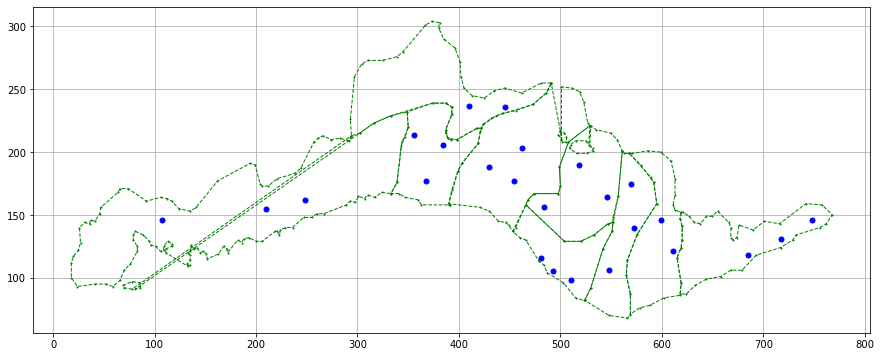

In [12]:
# buat plotting dari koordinat kecamatan dan koordinat pin marker yang telah didapatkan
# hal ini semata-mata hanya untuk melihat hasil extract data
plt.figure(figsize=(15,6))
for i in range(len(x_coor)):
    if i <= 8:
        plt.plot(X[i], Y[i], 'go--', linewidth=1, markersize=1)
        
    
    plt.plot(x_coor[i], y_coor[i], 'bo--', linewidth=1, markersize=5)

plt.grid(True)

In [13]:
# examine whether a pin's location is inside a given kecamatan area
# if TRUE, then all attributes regarding such a pin belongs to the given kecamatan
# if FALSE, then the given kecamatan doesn't own the pin

# empty lists to store the actual number and type of all kecamatan, respectively
# these lists below will be lists of lists
jumlahPerKec = []
tipePerKec = []

# for-looping through all kecamatan - X list contains a list of coordinates of each kecamatan
for i in range(len(X)):
    # change the x and y coordinates of given kecamatan into an array
    # it's needed as the matplotlib.Path func only receive arrays
    KecArray = np.array([[X[i][j],Y[i][j]] for j in range(len(X[i]))])
    
    # empty lists to store temporary number and type for each kecamatan
    jumlah = []
    tipe = []
    
    # create a polygon of given kecamatan
    mapPath = mplPath.Path(KecArray)
    
    # then for given kecamatan, loop through all pins
    for k in range(len(x_coor)):
        # set the coordinate of given pin
        pin = (x_coor[k], y_coor[k])
        
        # examine whether given pin is inside given kecamatan's polygon
        isInside = mapPath.contains_point(pin)
        # if TRUE, store all given pin's attrs
        if isInside:
            jumlah.append(numList[k])
            tipe.append(tipeList[k])
            
    # append the temporary lists to create lists of lists
    jumlahPerKec.append(jumlah)
    tipePerKec.append(tipe)

In [14]:
# ambil data mengenai warna tiap peta kecamatan
# warna tsb mengindikasi zona tiap kecamatan
# data warna tsb berada di tag 'path' dengan atribut class 'leaflet-interactive',
# lalu di dalam atribut 'fill'
fillList = [] # buat list kosong yang akan menyimpan data atribut 'fill'
for i in soupBuleleng.findAll('path', class_='leaflet-interactive'):
    fillList.append(i.get('fill'))

In [15]:
# define necessary variables
allkec_paths = soupBuleleng.findAll('path', class_='leaflet-interactive')
xpath_popup = '//*[@id="mapid"]/div[1]/div[6]/div/div[1]/div/b'
xpath_close_popup = '//*[@id="mapid"]/div[1]/div[6]/div/a'
xpath_zoomout = '//*[@id="mapid"]/div[2]/div[1]/div/a[2]'
kec = []

In [28]:
# instantiate the webdriver
driver = webdriver.Chrome()
driver.get(url)

# wait until the map appeared
wait = WebDriverWait(driver, 10)
wait.until(EC.visibility_of_all_elements_located((By.ID, "mapid")))

# maximize window
driver.maximize_window()
time.sleep(1)

# scroll down 1500 pixel.
driver.execute_script("window.scrollTo(0, 1500)")
time.sleep(1)

# scrape the webpage using beautifulsoup
soupBuleleng = bs(driver.page_source, 'html5lib')

# for-looping through all kecamatan to click each to get its name
for i in range(len(allkec_paths)):
    flag_doubleclick = 0 # set a flag to store how many times double-click executed in each kecamatan
    
    # define CSS_selector and the element for each kecamatan area
    cssSelector_kec = f'#mapid > div.leaflet-pane.leaflet-map-pane > div.leaflet-pane.leaflet-overlay-pane > svg > g > path:nth-child({i+1})'
    element = driver.find_element_by_css_selector(cssSelector_kec)
    
    # while-looping trying to click a kecamatan element until no error found
    while True:
        # try clicking each kecamatan area
        try:
            element.click()
            time.sleep(0.5) # wait until the popup shows up
            kec.append(driver.find_element_by_xpath(xpath_popup).text) # get the kecamatan name
            driver.find_element_by_xpath(xpath_close_popup).click() # close pop-up
            time.sleep(0.5) # wait until the popup closed properly
            
            # zoom-out as many as times double clicks performs
            for z in range(flag_doubleclick):
                driver.find_element_by_xpath(xpath_zoomout).click()
                time.sleep(0.5)  # wait until zoom-out responding
            break # finished with given kecamatan, then break the while loop
            
        # if can't be clicked due to overlapping, double click the element to make it zoomed in
        # it is expected that while zooming-in, the element can be clickable
        except:
            flag_doubleclick += 1 # store the flag
            webdriver.ActionChains(driver).double_click(element).perform()    

In [29]:
driver.quit()

In [20]:
tipePerKec

[['positif', 'pdp', 'otg'],
 ['positif', 'pdp', 'otg'],
 ['pdp', 'otg'],
 ['positif', 'pdp', 'otg'],
 ['positif', 'pdp', 'otg'],
 ['pdp', 'otg'],
 ['positif', 'pdp', 'otg'],
 ['positif', 'pdp', 'otg'],
 ['positif', 'pdp', 'otg']]

In [21]:
jumlahPerKec

[[4, 2, 5],
 [29, 11, 110],
 [1, 9],
 [3, 2, 28],
 [8, 3, 13],
 [1, 4],
 [9, 6, 5],
 [3, 1, 26],
 [3, 2, 17]]

In [22]:
kec

['Banjar',
 'Buleleng',
 'Busungbiu',
 'Sawan',
 'Seririt',
 'Kubutambahan',
 'Sukasada',
 'Tejakula',
 'Gerokgak']

In [25]:
# data = 
{k:(tipe, num) for k, tipe, num in zip(kec, tipePerKec, jumlahPerKec)}

{'Banjar': (['positif', 'pdp', 'otg'], [4, 2, 5]),
 'Buleleng': (['positif', 'pdp', 'otg'], [29, 11, 110]),
 'Busungbiu': (['pdp', 'otg'], [1, 9]),
 'Sawan': (['positif', 'pdp', 'otg'], [3, 2, 28]),
 'Seririt': (['positif', 'pdp', 'otg'], [8, 3, 13]),
 'Kubutambahan': (['pdp', 'otg'], [1, 4]),
 'Sukasada': (['positif', 'pdp', 'otg'], [9, 6, 5]),
 'Tejakula': (['positif', 'pdp', 'otg'], [3, 1, 26]),
 'Gerokgak': (['positif', 'pdp', 'otg'], [3, 2, 17])}

# Scrolling page in a webpage with multiple scrollbars

In [47]:
import math

url = 'https://covid19.who.int/table' # get url
# start selenium
driver = webdriver.Chrome()
# driver = webdriver.Chrome(options = option)
driver.get(url)
driver.maximize_window()

# must point to the element with the scroll bar (not the element alone)
# Note: querySelector uses CSS selector
css_selector = "#gatsby-focus-wrapper > div > div.sc-AxjAm.sc-AxhCb.dINWAn > div > div.sc-AxjAm.sc-pczax.djQmRP > div > div > div.tbody > div"
               
scrolling_step = 100  # In pixels
height = driver.execute_script("return document.querySelector('" + css_selector + "').scrollHeight")  # height (in pixels) for scrolling
times = math.ceil(height / scrolling_step)

# scrolling
for i in range(times):
    driver.execute_script("document.querySelector('" + css_selector + "').scrollTop = " + str(scrolling_step * (i + 1)))

In [48]:
driver.quit()